# Modelisation segmentation olist

## Import des librairies

In [2]:
import hdbscan
from sklearn.preprocessing import LabelEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer
import pandas as pd
import numpy as np
from sklearn.cluster import k_means
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Import des données

In [3]:
df_segmentation = pd.read_csv('df_preprocessing.csv')
df_segmentation = df_segmentation.set_index('identifiant_client')
df_segmentation.head()

,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services
identifiant_client,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.829066,-0.162673,0.020830,1,642,25,1,7,0.509722,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.809404,-0.162673,-0.801986,1,2557,25,2,43,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,0.067001,-0.078251,-0.051336,-0.02455
0000f46a3911fa3c0805444483337064,1.962945,-0.162673,-0.430607,1,3468,23,6,66,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455
0000f6ccb0745a6a4b88665a16c9f078,0.547278,-0.162673,-0.749430,1,441,13,1,68,-0.263807,0.160607,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455
0004aac84e0df4da2b147fca70cf8255,0.330995,-0.162673,0.392209,1,3706,25,3,68,-0.263807,1.326736,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455


## Modélisation clustering : Test de différents modèles 

Nous allons maintenant testé différents modèle de clustering et choisir le plus pertinant pour nos données. Pour tester le K-means, nous allons utiliser utiliser seulement, les variables numériques dans notre jeux de données, car en effet le l'algorithme k-means gère difficilement les variables catégorielles ce qui peut créer des résultats faussés.

### K-mean

In [4]:
# Create dataframe for kmeans model and evaluation
# Keep only numerical for kmeans
columns_depense = df_segmentation.filter(like='dépense').columns
other_columns = ['récence', 'fréquence', 'montant']
all_columns = list(columns_depense) + other_columns
# Merge all columns selected to a new dataframe
df_kmean_segmentation = df_segmentation[all_columns]
df_kmean_segmentation.head()

,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,récence,fréquence,montant
identifiant_client,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.509722,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,-0.829066,-0.162673,0.020830
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,0.067001,-0.078251,-0.051336,-0.02455,-0.809404,-0.162673,-0.801986
0000f46a3911fa3c0805444483337064,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,1.962945,-0.162673,-0.430607
0000f6ccb0745a6a4b88665a16c9f078,-0.263807,0.160607,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.547278,-0.162673,-0.749430
0004aac84e0df4da2b147fca70cf8255,-0.263807,1.326736,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.330995,-0.162673,0.392209


### Recherche du meilleur nombres de clusters

#### Elbow

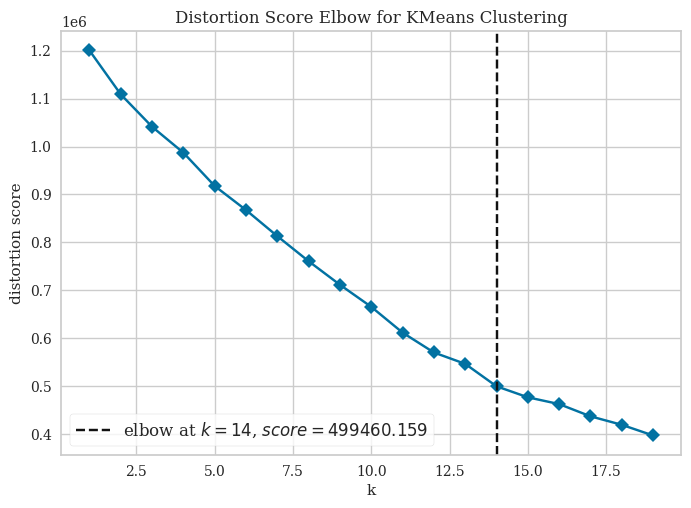

In [5]:

# Instantiate the clustering model and visualizer
model = KMeans(max_iter=500, n_init=10, random_state=42)
# Visualize the optimal number of clusters kmeans
visualizer = KElbowVisualizer(model, k=(1, 20), timings=False)
visualizer.fit(df_kmean_segmentation)
visualizer.show()
# Capture the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

#### Silhouette Score

In [61]:
silhouette_scores = []
for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    print(f"Calculating Silhouette score for {n_clusters} clusters...")
    cluster_labels = kmeans.fit_predict(df_kmean_segmentation)
    silhouette_avg = silhouette_score(df_kmean_segmentation, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Convert to DataFrame for easier viewing
silhouette_df = pd.DataFrame(silhouette_scores, columns=[
                             'n_clusters', 'silhouette_score'])

# Find the best score and corresponding number of clusters
best_n_clusters_silhouette = silhouette_df.loc[silhouette_df['silhouette_score'].idxmax(
)]

print("Best Silhouette Score:")
print(best_n_clusters_silhouette)

Calculating Silhouette score for 2 clusters...
Calculating Silhouette score for 3 clusters...
Calculating Silhouette score for 4 clusters...
Calculating Silhouette score for 5 clusters...


KeyboardInterrupt: 

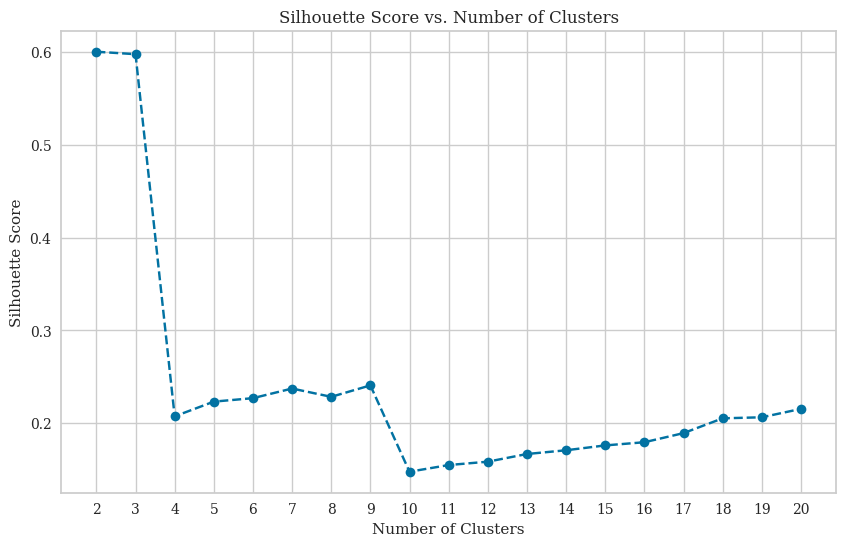

In [ ]:
# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(silhouette_df['n_clusters'],
         silhouette_df['silhouette_score'], marker='o', linestyle='--')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

In [ ]:

davies_bouldin_scores = []

for n_clusters in range(2, 21):
    print(f"Calculating Davies-Bouldin score for {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_kmean_segmentation)
    db_score = davies_bouldin_score(df_kmean_segmentation, cluster_labels)
    davies_bouldin_scores.append((n_clusters, db_score))

# Convert to DataFrame for easier viewing
davies_bouldin_df = pd.DataFrame(davies_bouldin_scores, columns=[
                                 'n_clusters', 'davies_bouldin_score'])

# Find the best score and corresponding number of clusters (lowest score is better)
best_n_clusters_davies_bouldin = davies_bouldin_df.loc[davies_bouldin_df['davies_bouldin_score'].idxmin(
)]

print("Best Davies-Bouldin Index:")
print(best_n_clusters_davies_bouldin)

Calculating Davies-Bouldin score for 2 clusters...
Calculating Davies-Bouldin score for 3 clusters...
Calculating Davies-Bouldin score for 4 clusters...
Calculating Davies-Bouldin score for 5 clusters...
Calculating Davies-Bouldin score for 6 clusters...
Calculating Davies-Bouldin score for 7 clusters...
Calculating Davies-Bouldin score for 8 clusters...
Calculating Davies-Bouldin score for 9 clusters...
Calculating Davies-Bouldin score for 10 clusters...
Calculating Davies-Bouldin score for 11 clusters...
Calculating Davies-Bouldin score for 12 clusters...
Calculating Davies-Bouldin score for 13 clusters...
Calculating Davies-Bouldin score for 14 clusters...
Calculating Davies-Bouldin score for 15 clusters...
Calculating Davies-Bouldin score for 16 clusters...
Calculating Davies-Bouldin score for 17 clusters...
Calculating Davies-Bouldin score for 18 clusters...
Calculating Davies-Bouldin score for 19 clusters...
Calculating Davies-Bouldin score for 20 clusters...
Best Davies-Bouldin 

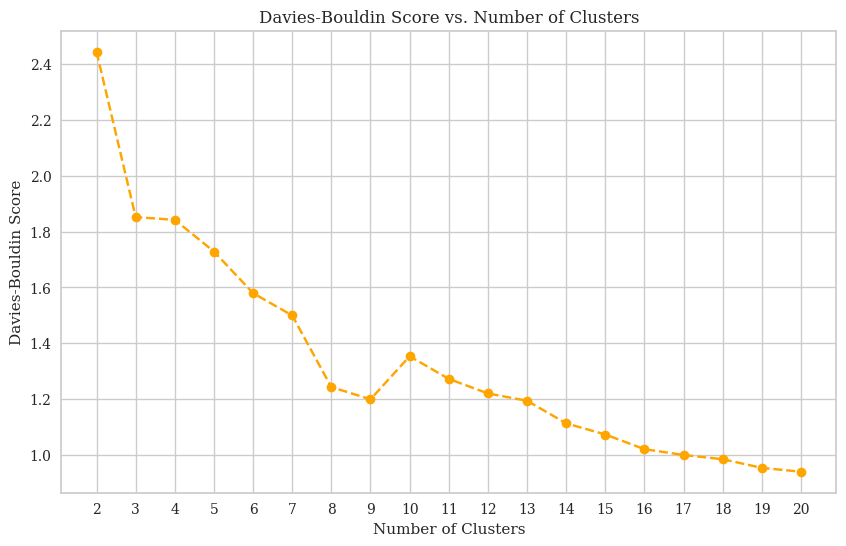

In [ ]:
# Plotting Davies-Bouldin Scores
plt.figure(figsize=(10, 6))
plt.plot(davies_bouldin_df['n_clusters'], davies_bouldin_df['davies_bouldin_score'],
         marker='o', linestyle='--', color='orange')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

In [ ]:
calinski_harabasz_scores = []

for n_clusters in range(2, 21):
    print(f"Calculating calinski harabasz score for {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_kmean_segmentation)
    ch_score = calinski_harabasz_score(df_kmean_segmentation, cluster_labels)
    calinski_harabasz_scores.append((n_clusters, ch_score))

# Convert to DataFrame for easier viewing
calinski_harabasz_df = pd.DataFrame(calinski_harabasz_scores, columns=[
                                    'n_clusters', 'calinski_harabasz_score'])

# Find the best score and corresponding number of clusters
best_n_clusters_calinski_harabasz = calinski_harabasz_df.loc[
    calinski_harabasz_df['calinski_harabasz_score'].idxmax()]

print("Best Calinski-Harabasz Index:")
print(best_n_clusters_calinski_harabasz)

Calculating calinski harabasz score for 2 clusters...
Calculating calinski harabasz score for 3 clusters...
Calculating calinski harabasz score for 4 clusters...
Calculating calinski harabasz score for 5 clusters...
Calculating calinski harabasz score for 6 clusters...
Calculating calinski harabasz score for 7 clusters...
Calculating calinski harabasz score for 8 clusters...
Calculating calinski harabasz score for 9 clusters...
Calculating calinski harabasz score for 10 clusters...
Calculating calinski harabasz score for 11 clusters...
Calculating calinski harabasz score for 12 clusters...
Calculating calinski harabasz score for 13 clusters...
Calculating calinski harabasz score for 14 clusters...
Calculating calinski harabasz score for 15 clusters...
Calculating calinski harabasz score for 16 clusters...
Calculating calinski harabasz score for 17 clusters...
Calculating calinski harabasz score for 18 clusters...
Calculating calinski harabasz score for 19 clusters...
Calculating calins

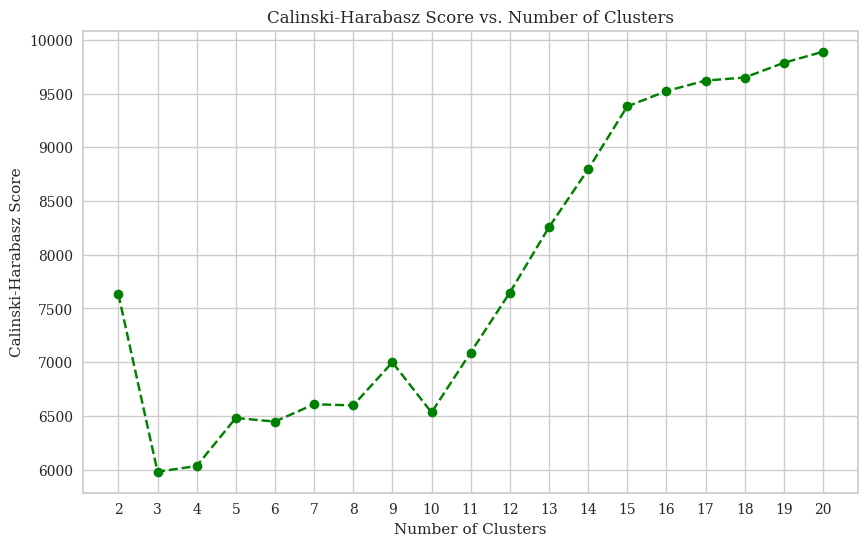

In [ ]:
# Plotting Calinski-Harabasz Scores
plt.figure(figsize=(10, 6))
plt.plot(calinski_harabasz_df['n_clusters'], calinski_harabasz_df['calinski_harabasz_score'],
         marker='o', linestyle='--', color='green')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

Avec les résultats suivi ont peut remarquer que le bon de clusters a choisir est 14

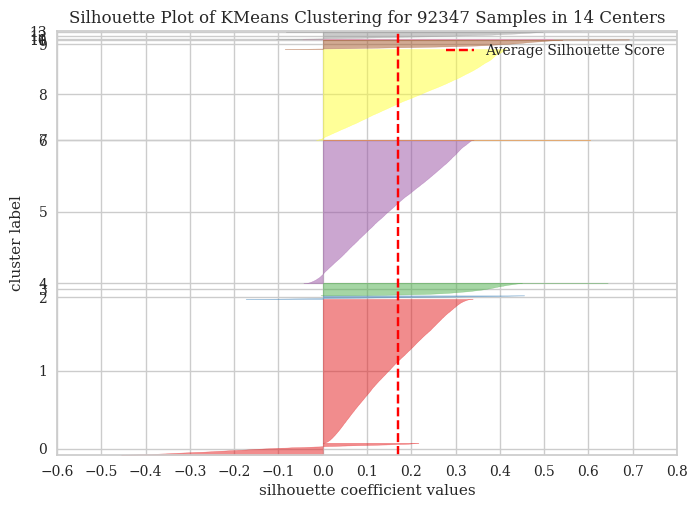

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 92347 Samples in 14 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [6]:
# Initialisation

# k-means with best cluster
kmeans_segmentation = KMeans(
    n_clusters=optimal_clusters, init='k-means++', random_state=42, max_iter=500)
# Fit the K-Means model and predict the cluster labels
df_kmean_segmentation['Cluster_Label'] = kmeans_segmentation.fit_predict(
    df_kmean_segmentation)

# Evaluation
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(
    df_kmean_segmentation, df_kmean_segmentation['Cluster_Label'])
df_kmean_segmentation['Silhouette_Score'] = silhouette_avg

# Calculate the Davies-Bouldin Index
db_score = davies_bouldin_score(
    df_kmean_segmentation, df_kmean_segmentation['Cluster_Label'])
df_kmean_segmentation['Davies_Bouldin_Score'] = db_score

# Calculate the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(
    df_kmean_segmentation, df_kmean_segmentation['Cluster_Label'])
df_kmean_segmentation['Calinski_Harabasz_Score'] = ch_score
# List of columns to exclude (evaluation metrics and cluster labels)
exclude_columns = ['Calinski_Harabasz_Score',
                   'Cluster_Label', 'Davies_Bouldin_Score', 'Silhouette_Score']

# Select only the features used for K-Means clustering
kmeans_features = df_kmean_segmentation.drop(columns=exclude_columns)
# Visualisation
# Visualize the clusters with Silhouette Visualizer
visualizer = SilhouetteVisualizer(kmeans_segmentation, k=optimal_clusters)
visualizer.fit(kmeans_features)
visualizer.show()

In [ ]:
display(df_kmean_segmentation)

,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,récence,fréquence,montant,Cluster_Label,Silhouette_Score,Davies_Bouldin_Score,Calinski_Harabasz_Score
identifiant_client,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.509722,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,-0.829066,-0.162673,0.020830,5,0.572925,0.79598,19875.669707
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,0.067001,-0.078251,-0.051336,-0.02455,-0.809404,-0.162673,-0.801986,5,0.572925,0.79598,19875.669707
0000f46a3911fa3c0805444483337064,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,1.962945,-0.162673,-0.430607,8,0.572925,0.79598,19875.669707
0000f6ccb0745a6a4b88665a16c9f078,-0.263807,0.160607,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.547278,-0.162673,-0.749430,1,0.572925,0.79598,19875.669707
0004aac84e0df4da2b147fca70cf8255,-0.263807,1.326736,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.330995,-0.162673,0.392209,1,0.572925,0.79598,19875.669707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.548426,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.049172,-0.162673,0.162413,1,0.572925,0.79598,19875.669707
fffea47cd6d3cc0a88bd621562a9d061,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,1.195061,-0.051336,-0.02455,0.160591,-0.162673,-0.461073,1,0.572925,0.79598,19875.669707
ffff371b4d645b6ecea244b27531430a,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,0.729441,-0.235404,-0.078251,-0.051336,-0.02455,2.166120,-0.162673,-0.275680,8,0.572925,0.79598,19875.669707


In [ ]:
df_kmean_segmentation['Silhouette_Score'].mean()

0.5729246537044378

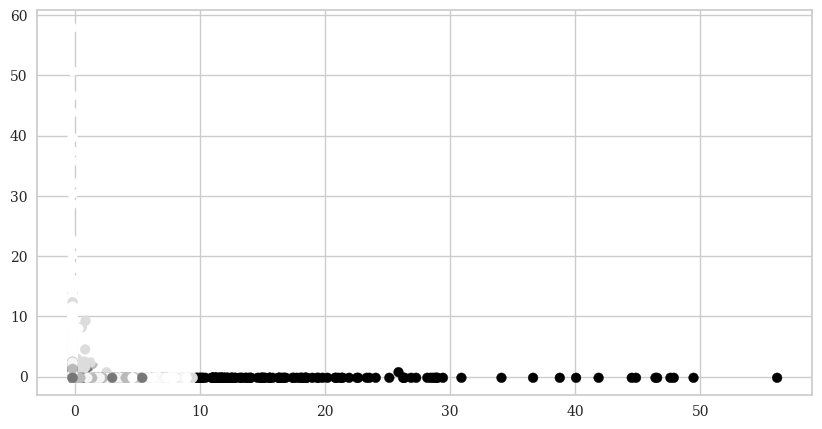

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(x=df_kmean_segmentation.iloc[:, 1],
            y=df_kmean_segmentation.iloc[:, 2], c=kmeans_segmentation.labels_)

### K-mean (avec ACP)

#### ACP Transformation 

In [ ]:
acp = PCA(random_state=42)
acp.fit(kmeans_features)

PCA(random_state=42)

In [ ]:
acp.explained_variance_ratio_
explained_variance_ratio = acp.explained_variance_ratio_

([<matplotlib.axis.XTick at 0x78b354dc99a0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13')])

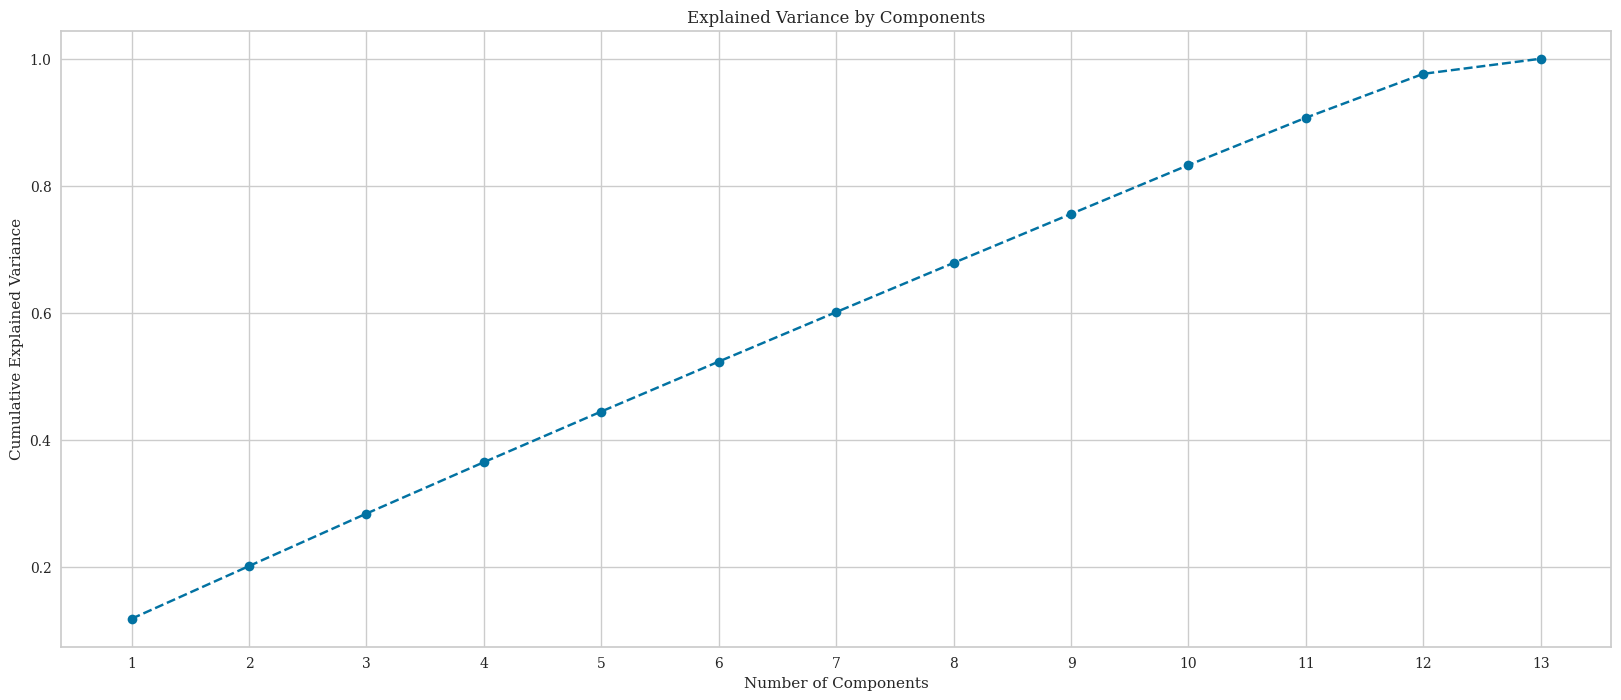

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio.cumsum(),
         marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))

10 composent explique 80% de la variance 

In [ ]:
# Choose number of component ACP
acp = PCA(n_components=2)
# fit data with ACP
acp.fit(kmeans_features)
components = acp.components_

In [ ]:
score_acp_k_means = acp.transform(kmeans_features)

In [ ]:
# Application du K-Means sur les données transformées par l'ACP
kmeans_with_acp = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_with_acp.fit(score_acp_k_means)

KMeans(n_clusters=14, random_state=42)

In [ ]:
# Create a new Dataframe to result of ACP
df_segment_acp_kmeans = pd.concat([kmeans_features.reset_index(
    drop=True), pd.DataFrame(score_acp_k_means)], axis=1)
df_segment_acp_kmeans.columns.values[-2:] = ['component_1', 'component_2']
df_segment_acp_kmeans["segment_kmeans_acp"] = kmeans_with_acp.labels_
df_kmean_segmentation = df_kmean_segmentation.reset_index(drop=True)
df_segment_acp_kmeans = df_segment_acp_kmeans.reset_index(drop=True)
# Add result to Principal Dataframe
df_kmean_segmentation['component_1'] = df_segment_acp_kmeans['component_1']
df_kmean_segmentation['component_2'] = df_segment_acp_kmeans['component_2']
df_kmean_segmentation['segment_kmeans_acp'] = df_segment_acp_kmeans['segment_kmeans_acp']


df_kmean_segmentation.head()

,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,récence,fréquence,montant,Cluster_Label,Silhouette_Score,Davies_Bouldin_Score,Calinski_Harabasz_Score,component_1,component_2,segment_kmeans_acp
0,0.509722,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,-0.829066,-0.162673,0.020830,5,0.572925,0.79598,19875.669707,-0.138803,0.612727,13
1,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,0.067001,-0.078251,-0.051336,-0.02455,-0.809404,-0.162673,-0.801986,5,0.572925,0.79598,19875.669707,-0.862559,-0.033426,8
2,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,1.962945,-0.162673,-0.430607,8,0.572925,0.79598,19875.669707,-0.739377,-0.152447,8
3,-0.263807,0.160607,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.547278,-0.162673,-0.749430,1,0.572925,0.79598,19875.669707,-0.856788,-0.095447,8
4,-0.263807,1.326736,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.330995,-0.162673,0.392209,1,0.572925,0.79598,19875.669707,0.238824,-0.396328,1


In [ ]:
mapping = {
    0: 'premier',
    1: 'deuxième',
    2: 'troisième',
    3: 'quatrième',
    4: 'cinquième',
    5: 'sixième',
    6: 'septième',
    7: 'huitième',
    8: 'neuvième',
    9: 'dixième',
    10: 'onzième',
    11: 'douzième',
    12: 'treizième',
    13: 'quatorzième'
}

# Application du mapping pour créer la colonne 'segment'
df_segment_acp_kmeans['segment'] = df_segment_acp_kmeans['segment_kmeans_acp'].map(
    mapping)

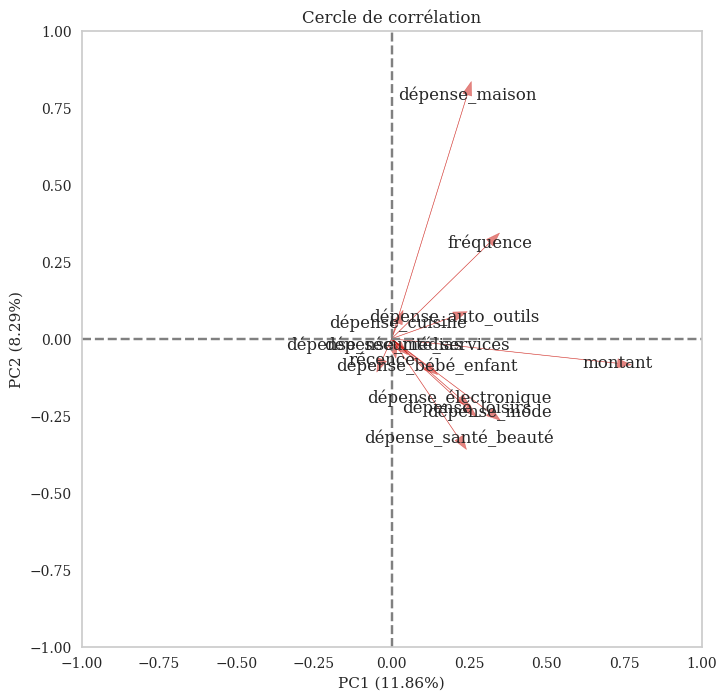

In [ ]:
# Plot du cercle de corrélation
def correlation_circle(components, labels, acp):
    plt.figure(figsize=(8, 8))
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    for i, (component_1, component_2) in enumerate(components.T[:, :2]):
        plt.arrow(0, 0, component_1, component_2,
                  color='r', alpha=0.5, head_width=0.03)
        plt.text(component_1, component_2, labels[i],
                 fontsize=12, ha='center', va='center')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f"PC1 ({acp.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({acp.explained_variance_ratio_[1]*100:.2f}%)")
    plt.title('Cercle de corrélation')
    plt.grid()
    plt.show()


# Noms des colonnes pour les étiquettes
labels = kmeans_features.columns

# Création du cercle de corrélation
correlation_circle(components, labels, acp)

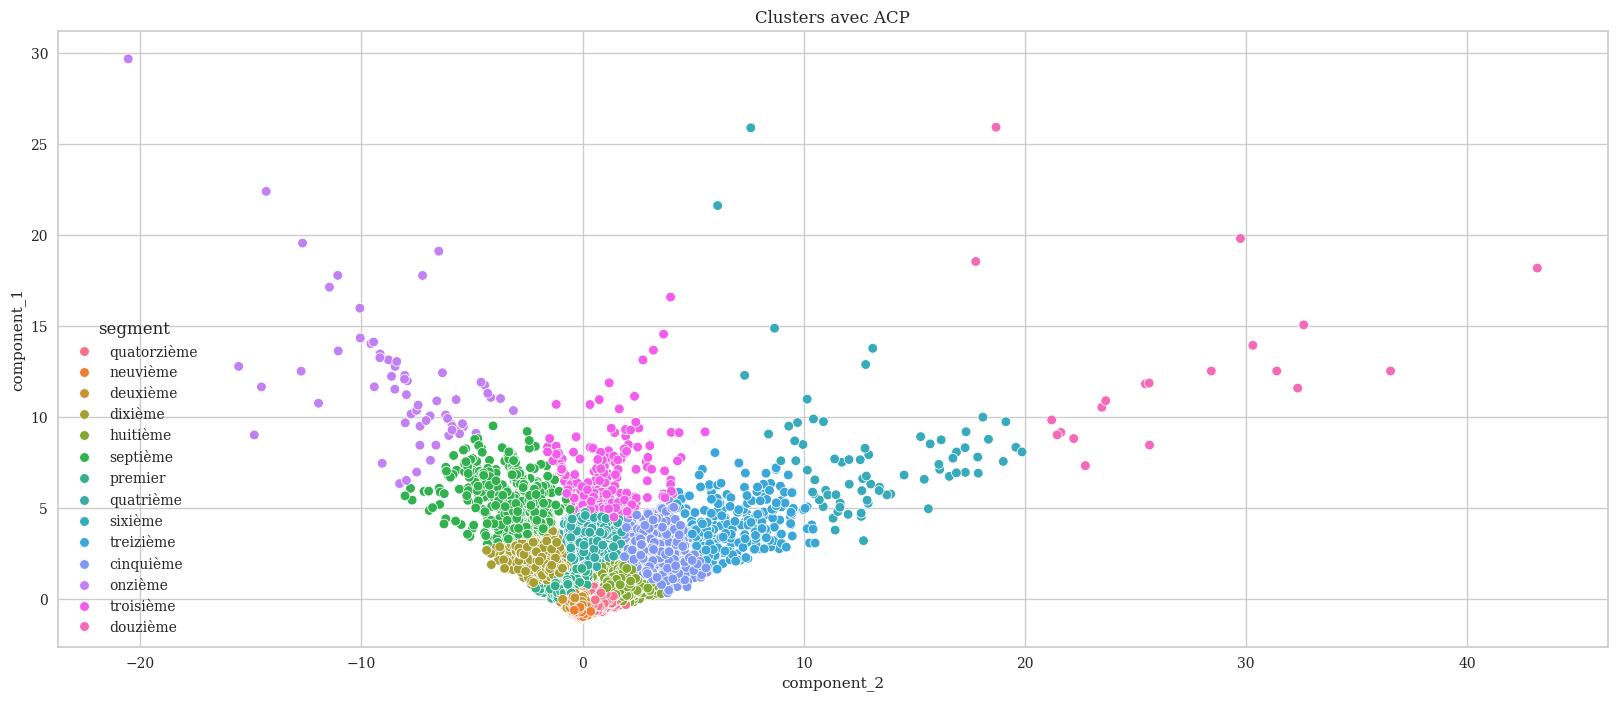

In [ ]:
# Plot data by PCA component
x_axis = df_segment_acp_kmeans['component_2']
y_axis = df_segment_acp_kmeans['component_1']
plt.figure(figsize=(20, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segment_acp_kmeans['segment'])
plt.title('Clusters avec ACP')
plt.show()

### K-means (avec TSNE)

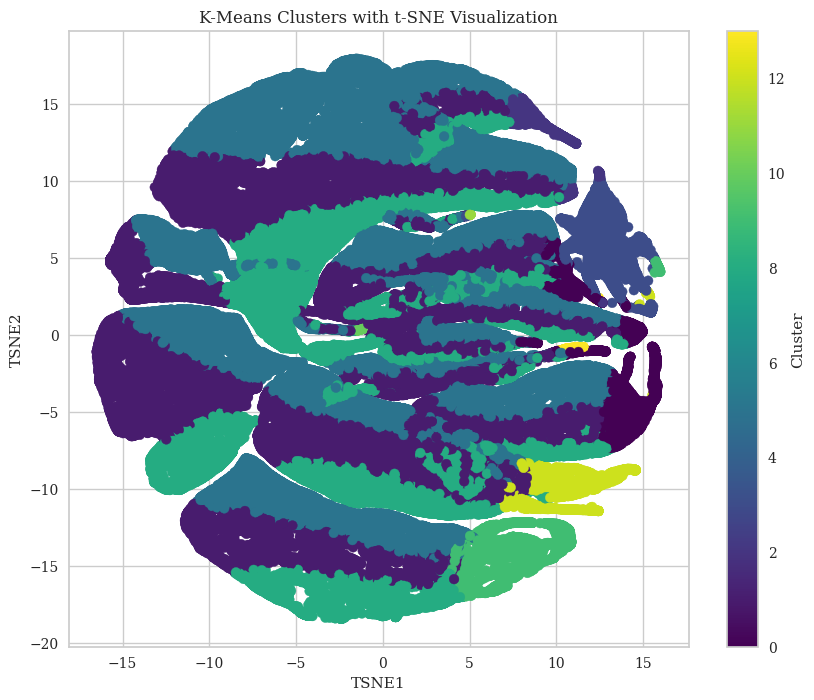

In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_kmean_segmentation['Cluster_TSNE'] = kmeans.fit_predict(kmeans_features)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(kmeans_features)

# Add t-SNE results to the DataFrame
df_kmean_segmentation['TSNE1'] = tsne_results[:, 0]
df_kmean_segmentation['TSNE2'] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_kmean_segmentation['TSNE1'], df_kmean_segmentation['TSNE2'],
            c=df_kmean_segmentation['Cluster_TSNE'], cmap='viridis')
plt.title('K-Means Clusters with t-SNE Visualization')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
display(df_kmean_segmentation)

NameError: name 'df_kmean_segmentation' is not defined

## K-prototypes

In [ ]:
# Preprocess the data
categorical_columns = ['type_de_paiement_préféré', 'ville_client',
                       'état_client', 'jour_avec_plus_de_commandes', 'catégorie_préférée']
numerical_columns = df_segmentation.columns.difference(
    categorical_columns).tolist()

for col in categorical_columns:
    df_segmentation[col] = df_segmentation[col].astype('category')

df_segmentation_kprototype = df_segmentation[categorical_columns +
                                             numerical_columns].copy()

# Convert categorical columns to their codes
for col in categorical_columns:
    df_segmentation_kprototype[col] = df_segmentation_kprototype[col].cat.codes

# Get the indices of categorical columns
categorical_indices = [df_segmentation_kprototype.columns.get_loc(
    col) for col in categorical_columns]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 23645, ncost: 1298221.2814308917
Run: 1, iteration: 2/100, moves: 11361, ncost: 1291754.3877674993
Run: 1, iteration: 3/100, moves: 4343, ncost: 1290069.4500440627
Run: 1, iteration: 4/100, moves: 2280, ncost: 1289526.2131090912
Run: 1, iteration: 5/100, moves: 1591, ncost: 1289289.3540669638
Run: 1, iteration: 6/100, moves: 1046, ncost: 1289191.411054408
Run: 1, iteration: 7/100, moves: 769, ncost: 1289134.2668723448
Run: 1, iteration: 8/100, moves: 490, ncost: 1289115.805207439
Run: 1, iteration: 9/100, moves: 335, ncost: 1289106.742018756
Run: 1, iteration: 10/100, moves: 259, ncost: 1289101.5404368404
Run: 1, iteration: 11/100, moves: 168, ncost: 1289099.3669569017
Run: 1, iteration: 12/100, moves: 92, ncost: 1289098.83552301
Run: 1, iteration: 13/100, moves: 57, ncost: 1289098.5809121537
Run: 1, iteration: 14/100, moves: 49, ncost: 1289098.4009038552
Run: 1, iteration: 

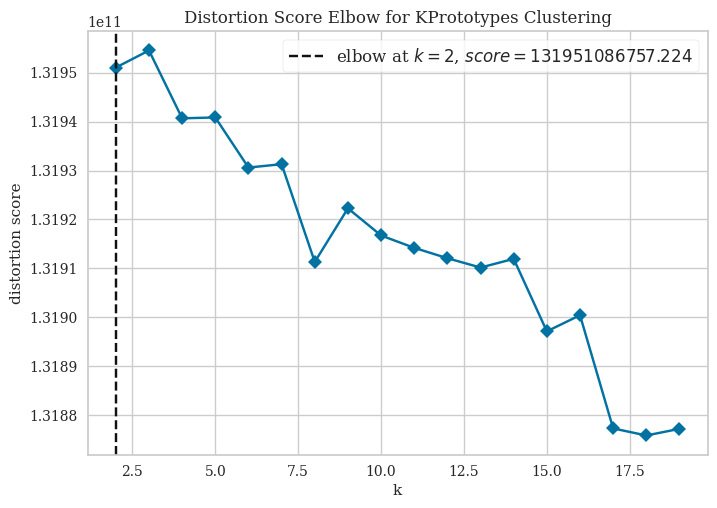

Optimal number of clusters: 2


In [ ]:
# Use KElbowVisualizer to find the optimal number of clusters

model = KPrototypes(random_state=42, init='Huang', n_init=1, verbose=1)
visualizer = KElbowVisualizer(
    model, k=(2, 20), metric='distortion', timings=False)
visualizer.fit(df_segmentation_kprototype, categorical=categorical_indices)
visualizer.show()


# Determine the optimal number of clusters
optimal_clusters = visualizer.elbow_value_
print(f'Optimal number of clusters: {optimal_clusters}')

In [ ]:
# Apply K-Prototypes clustering with the optimal number of clusters
kproto = KPrototypes(n_clusters=optimal_clusters, random_state=42)
clusters = kproto.fit_predict(
    df_segmentation_kprototype, categorical=categorical_indices)

# Assign cluster labels to the dataframe
df_segmentation_kprototype['Cluster_kproto'] = kproto.labels_


# Ensure data is in numeric format for score calculations
df_numeric = df_segmentation_kprototype.drop(columns=categorical_columns)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(
    df_numeric, df_segmentation_kprototype['Cluster_kproto'])

# Calculate Calinski-Harabasz Score
calinski_harabasz_avg = calinski_harabasz_score(
    df_numeric, df_segmentation_kprototype['Cluster_kproto'])

# Calculate Davies-Bouldin Score
davies_bouldin_avg = davies_bouldin_score(
    df_numeric, df_segmentation_kprototype['Cluster_kproto'])

# Add these scores to the DataFrame
df_segmentation_kprototype['Silhouette_Score'] = silhouette_avg
df_segmentation_kprototype['Calinski_Harabasz_Score'] = calinski_harabasz_avg
df_segmentation_kprototype['Davies_Bouldin_Score'] = davies_bouldin_avg

KeyboardInterrupt: 

In [ ]:
display(df_segmentation_kprototype)

,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,Cluster_kproto,PCA1,PCA2,TSNE1,TSNE2,...,dépense_loisirs,dépense_maison,dépense_mode,dépense_médias,dépense_santé_beauté,dépense_sécurité_services,dépense_électronique,fréquence,montant,récence
identifiant_client,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,648,25,1,7,2,-1708.536250,-31.916864,-10.946152,-4.831375,...,-0.206984,0.341400,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.074179,-0.825585
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2571,25,2,43,0,214.460509,4.149439,-0.201593,4.998458,...,-0.206984,-0.217053,-0.162143,-0.058154,0.034744,-0.008695,-0.066068,-0.200448,-0.574410,-0.805902
0000f46a3911fa3c0805444483337064,1,3486,23,6,66,4,1129.455646,27.191939,7.106353,3.074802,...,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.348630,1.969343
0000f6ccb0745a6a4b88665a16c9f078,1,444,13,1,68,2,-1912.556190,29.143837,-15.596094,8.502984,...,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,0.023856,-0.200448,-0.542459,0.552197
0004aac84e0df4da2b147fca70cf8255,1,3724,25,3,68,4,1367.458448,29.186559,9.847610,3.542367,...,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,0.339829,-0.200448,0.151602,0.335688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,3226,15,1,43,3,869.443961,4.344509,3.769821,-2.566673,...,-0.206984,-0.217053,-0.162143,-0.058154,35.908899,-0.008695,-0.066068,-0.200448,6.415765,1.378865
fffea47cd6d3cc0a88bd621562a9d061,1,1313,4,0,6,1,-1043.569592,-32.769431,-5.504343,-3.725498,...,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.367152,0.165106
ffff371b4d645b6ecea244b27531430a,1,3706,12,3,5,4,1349.439912,-33.728639,9.269689,-4.552242,...,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.254442,2.172730


### Visualisation PCA


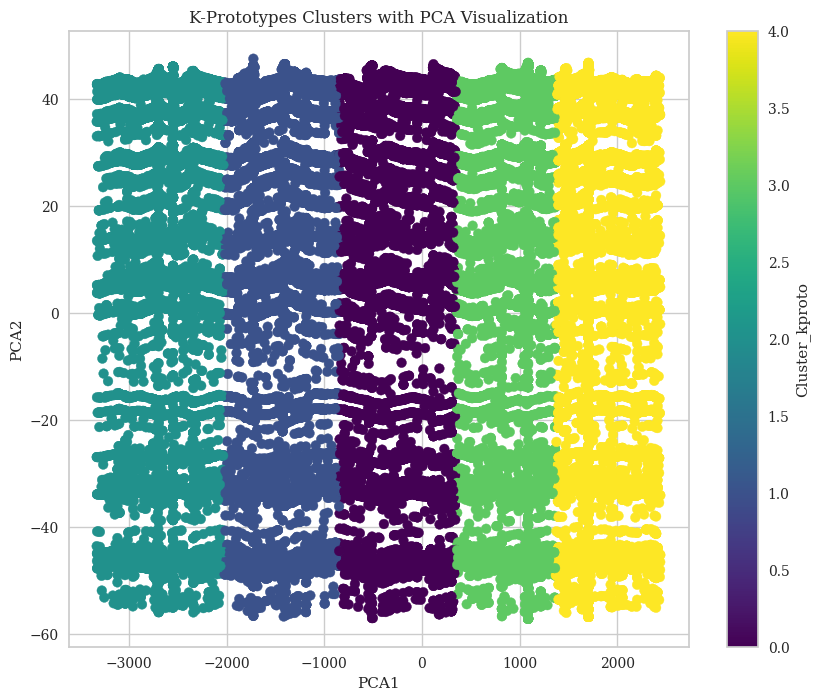

In [ ]:
# Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_segmentation_kprototype)

df_segmentation_kprototype['PCA1'] = pca_results[:, 0]
df_segmentation_kprototype['PCA2'] = pca_results[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(df_segmentation_kprototype['PCA1'], df_segmentation_kprototype['PCA2'],
            c=df_segmentation_kprototype['Cluster_kproto'], cmap='viridis')
plt.title('K-Prototypes Clusters with PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster_kproto')
plt.show()

### Visualisation TSNE

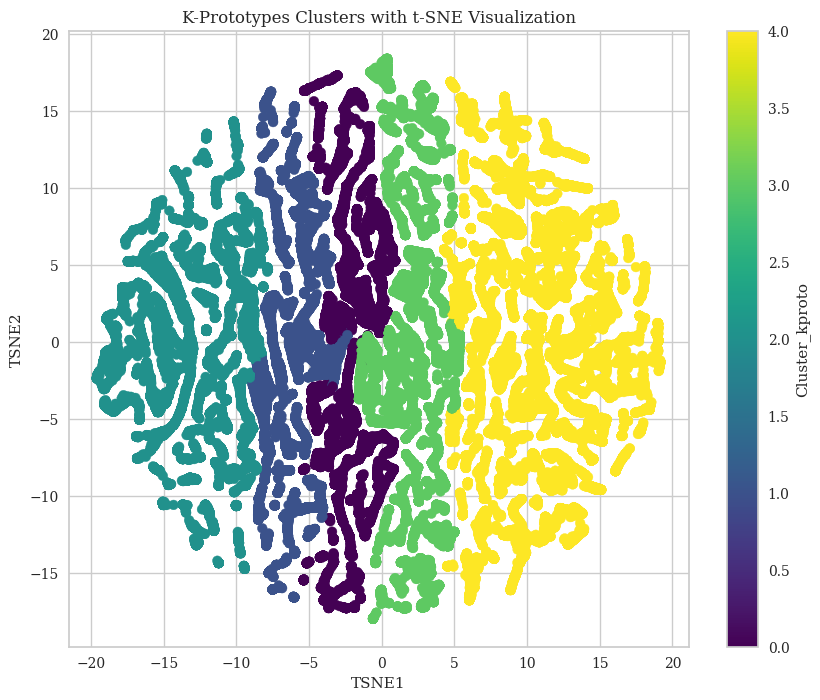

In [ ]:
# Visualize Clusters with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(df_segmentation_kprototype)

df_segmentation_kprototype['TSNE1'] = tsne_results[:, 0]
df_segmentation_kprototype['TSNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(df_segmentation_kprototype['TSNE1'], df_segmentation_kprototype['TSNE2'],
            c=df_segmentation_kprototype['Cluster_kproto'], cmap='viridis')
plt.title('K-Prototypes Clusters with t-SNE Visualization')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Cluster_kproto')
plt.show()

## Segmentation RFM analyse clustering

In [7]:
df_without_preprocessing = pd.read_csv('df_cleaning.csv')
df_without_preprocessing.set_index('identifiant_client')
# Réinitialiser les index si nécessaire
df1_reset = df_without_preprocessing.reset_index()
df2_reset = df_kmean_segmentation.reset_index()

# Fusionner en utilisant la colonne 'identifiant_client'
df_with_cluster = pd.merge(df1_reset, df2_reset[[
                           'identifiant_client', 'Cluster_Label']], on='identifiant_client', how='left')

# Réinitialiser l'index au besoin
df_with_cluster.set_index('identifiant_client', inplace=True)

# Afficher les premières lignes pour vérifier la fusion
display(df_with_cluster.head())

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label
identifiant_client,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,5
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,0.00,0.0,0.0,0.0,0.0,27.19,0.0,0.0,0.0,5
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,8
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,43.62,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,196.89,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1


### Création du Segment RFM

In [8]:
df_with_cluster["récence_score"] = pd.qcut(
    df_with_cluster['récence'], 5, labels=[5, 4, 3, 2, 1])
df_with_cluster["fréquence_score"] = pd.qcut(
    df_with_cluster['fréquence'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_with_cluster["montant_score"] = pd.qcut(
    df_with_cluster['montant'], 5, labels=[1, 2, 3, 4, 5])

In [9]:
df_with_cluster['RFM_SCORE'] = df_with_cluster.récence_score.astype(
    str) + df_with_cluster.fréquence_score.astype(str) + df_with_cluster.montant_score.astype(str)
df_with_cluster

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,...,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label,récence_score,fréquence_score,montant_score,RFM_SCORE
identifiant_client,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,...,0.00,0.00,0.00,0.0,0.0,5,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,...,0.00,27.19,0.00,0.0,0.0,5,4,1,1,411
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,...,0.00,0.00,0.00,0.0,0.0,8,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,...,0.00,0.00,0.00,0.0,0.0,1,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,...,0.00,0.00,0.00,0.0,0.0,1,2,1,5,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,92342,245.0,1,149.00,credit_card,fortaleza,CE,Mercredi,bed_bath_table,149.0,...,0.00,0.00,0.00,0.0,0.0,1,3,5,4,354
fffea47cd6d3cc0a88bd621562a9d061,92343,262.0,1,64.89,credit_card,feira de santana,BA,Dimanche,baby,0.0,...,0.00,0.00,84.58,0.0,0.0,1,3,5,2,352
ffff371b4d645b6ecea244b27531430a,92344,568.0,1,89.90,credit_card,sinop,MT,Mardi,auto,0.0,...,112.46,0.00,0.00,0.0,0.0,8,1,5,3,153


In [10]:
seg_map = {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [11]:
df_with_cluster['Segment'] = df_with_cluster['récence_score'].astype(
    str) + df_with_cluster['fréquence_score'].astype(str) + df_with_cluster['montant_score'].astype(str)
df_with_cluster['Segment'] = df_with_cluster['Segment'].replace(
    seg_map, regex=True)
df_with_cluster.head()

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,...,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label,récence_score,fréquence_score,montant_score,RFM_SCORE,Segment
identifiant_client,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,...,0.00,0.0,0.0,0.0,5,4,1,4,414,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,...,27.19,0.0,0.0,0.0,5,4,1,1,411,New Customers
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,...,0.00,0.0,0.0,0.0,8,1,1,2,112,Lost customers
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,...,0.00,0.0,0.0,0.0,1,2,1,1,211,Hibernating customers
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,...,0.00,0.0,0.0,0.0,1,2,1,5,215,Cannot Lose Them


### Analyse RFM sans clusters

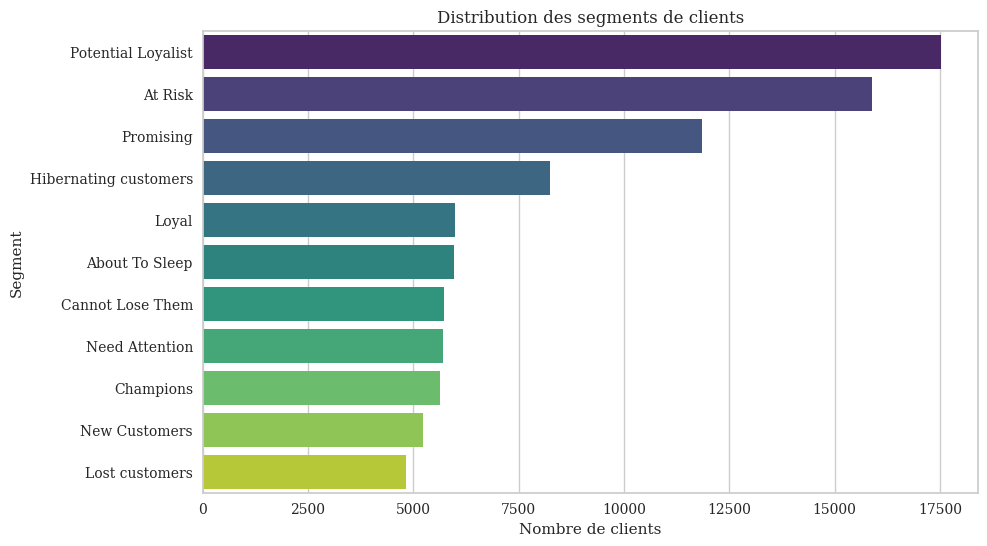

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the countplot, ordering by the frequency of each segment
sns.countplot(y='Segment', data=df_with_cluster,
              order=df_with_cluster['Segment'].value_counts().index, palette='viridis')

# Set the title and labels
plt.title('Distribution des segments de clients')
plt.xlabel('Nombre de clients')
plt.ylabel('Segment')

# Display the plot
plt.show()

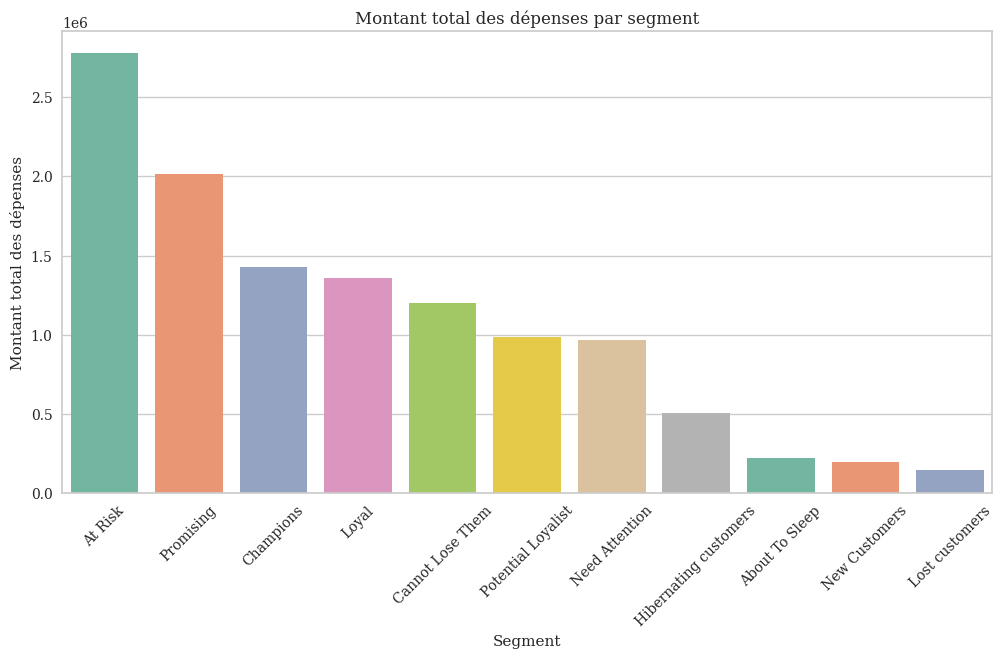

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment', y='montant', data=df_with_cluster, palette='Set2', estimator=sum, ci=None,
            order=df_with_cluster.groupby('Segment')['montant'].sum().sort_values(ascending=False).index)
plt.title('Montant total des dépenses par segment')
plt.xlabel('Segment')
plt.ylabel('Montant total des dépenses')
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Créer un DataFrame pour les segments et leurs comptes
df_treemap = df_with_cluster['Segment'].value_counts().reset_index()
df_treemap.columns = ['Segment', 'Count']

# Créer le treemap avec Plotly
fig = px.treemap(df_treemap,
                 path=['Segment'],
                 values='Count',
                 color='Count',  # Optionnel, pour ajouter des couleurs basées sur le compte
                 # Vous pouvez choisir la palette de couleurs que vous préférez
                 color_continuous_scale='RdYlGn',
                 title='Treemap des segments de clients')

# Afficher le treemap
fig.show()

### Analyse des segments clients avec les clusters

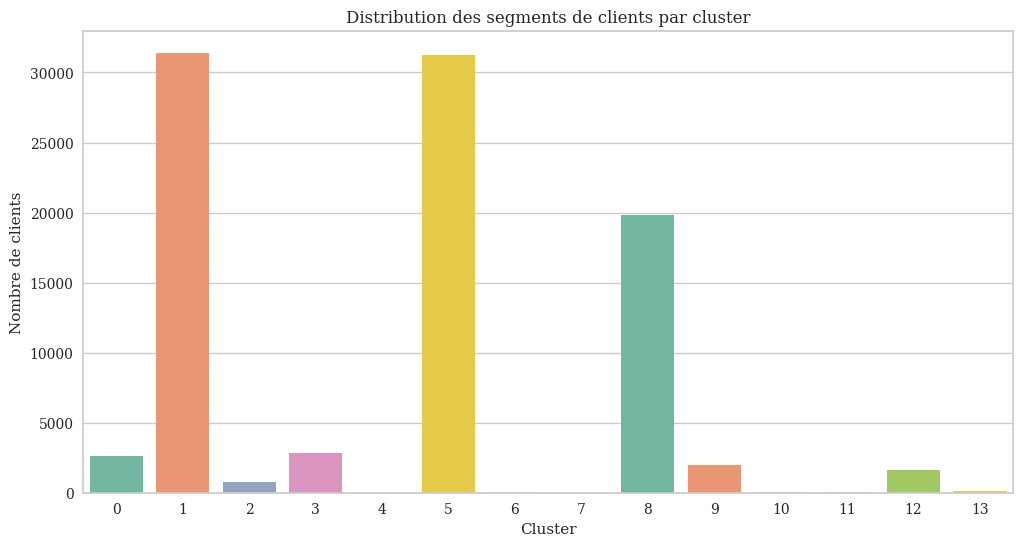

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_with_cluster, x='Cluster_Label', palette='Set2')
plt.title('Distribution des segments de clients par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.show()

In [19]:
# Filtrer le DataFrame pour les Cluster_Label spécifiques
filtered_clusters = df_with_cluster[df_with_cluster['Cluster_Label'].isin([
                                                                          4, 6, 7, 10, 11])]

# Compter le nombre de valeurs pour chaque Cluster_Label
cluster_counts = filtered_clusters['Cluster_Label'].value_counts()

# Afficher les résultats
print(cluster_counts)

Cluster_Label
10    69
11    41
6     24
4      4
7      1
Name: count, dtype: int64


In [20]:

cluster_label_4_df = df_with_cluster[df_with_cluster['Cluster_Label'] == 4]

# Afficher les résultats
display(cluster_label_4_df)

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,...,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label,récence_score,fréquence_score,montant_score,RFM_SCORE,Segment
identifiant_client,,,,,,,,,,,,,,,,,,,,,
064fb6f70338688d1372235d95d92ff7,2265,111.0,1,960.00,credit_card,rio de janeiro,RJ,Jeudi,construction_tools_construction,0.0,...,0.0,0.0,0.0,0.0,4,4,1,5,415,Promising
11f97da02237a49c8e783dfda6f50e8e,6545,576.0,1,765.00,credit_card,goiania,GO,Lundi,garden_tools,0.0,...,0.0,0.0,0.0,0.0,4,1,1,5,115,Cannot Lose Them
17fdbc7bf5923361a92c5630bdd80cd6,8744,299.0,1,935.94,credit_card,barra do garcas,MT,Vendredi,garden_tools,0.0,...,0.0,0.0,0.0,0.0,4,2,1,5,215,Cannot Lose Them
31e412b9fb766b6794724ed17a41dfa6,18095,259.0,1,826.00,boleto,santos,SP,Mercredi,garden_tools,0.0,...,0.0,0.0,0.0,0.0,4,3,1,5,315,Promising


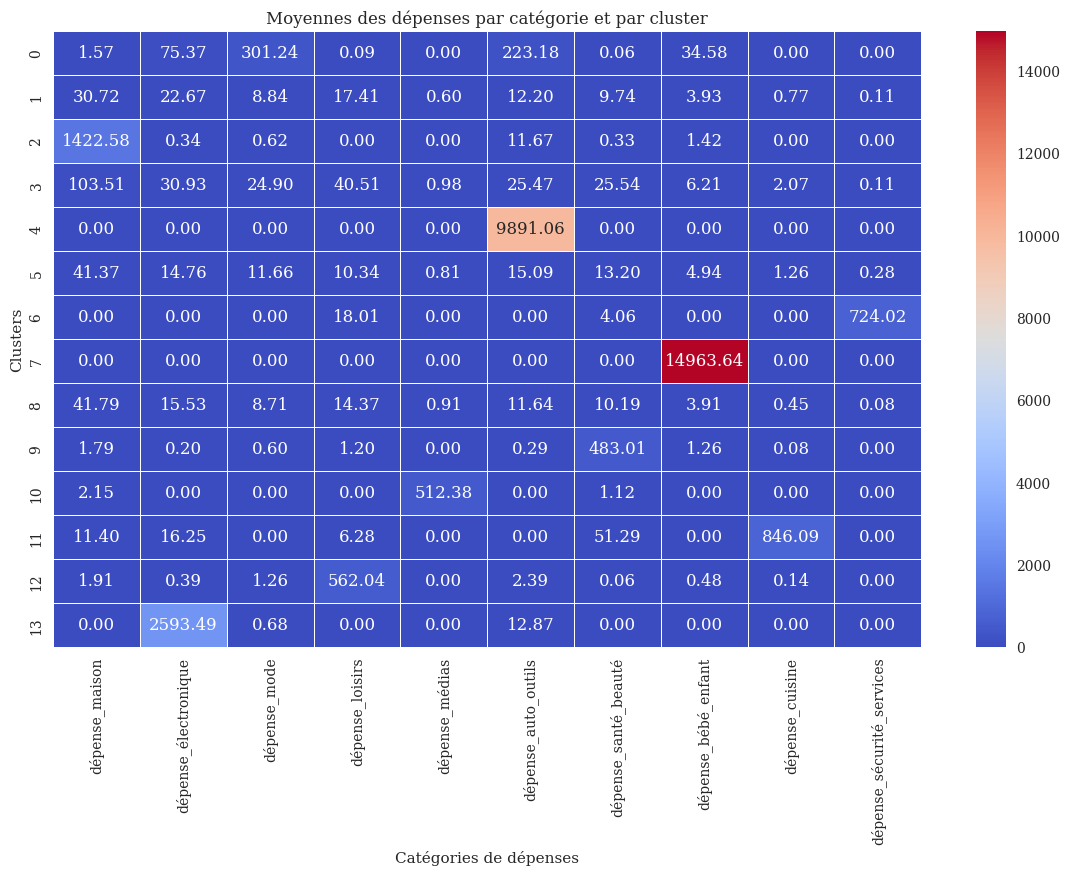

In [24]:
# Filtrer les colonnes numériques seulement pour le calcul des moyennes
numeric_cols = df_with_cluster.select_dtypes(include=['number']).columns

# Calculer la moyenne des dépenses par catégorie pour chaque cluster
depense_par_cluster = df_with_cluster.groupby(
    'Cluster_Label')[numeric_cols].mean().filter(like='dépense')

# Créer une heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(depense_par_cluster, annot=True,
            fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Moyennes des dépenses par catégorie et par cluster')
plt.xlabel('Catégories de dépenses')
plt.ylabel('Clusters')
plt.show()

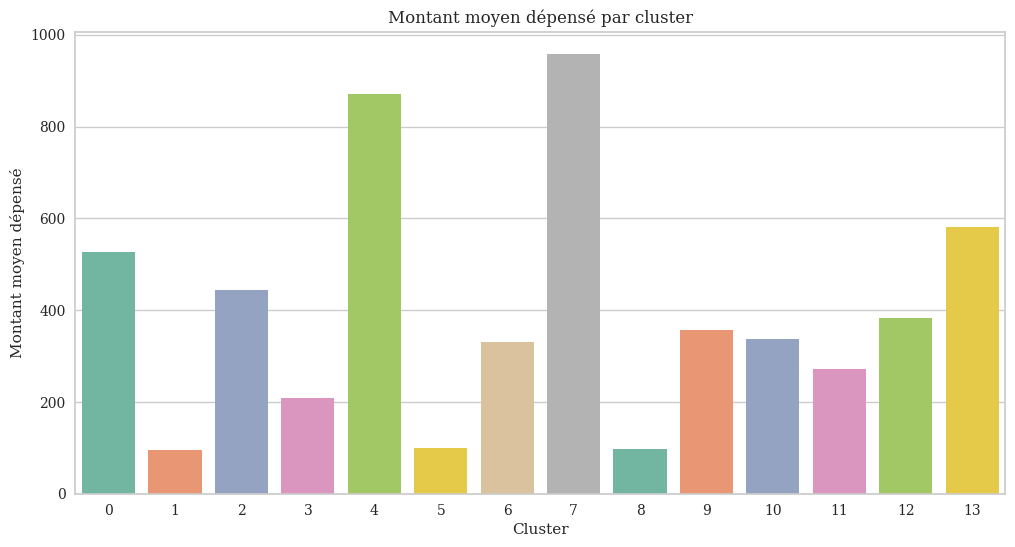

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_with_cluster, x='Cluster_Label',
            y='montant', palette='Set2', ci=None)
plt.title('Montant moyen dépensé par cluster')
plt.xlabel('Cluster')
plt.ylabel('Montant moyen dépensé')
plt.show()

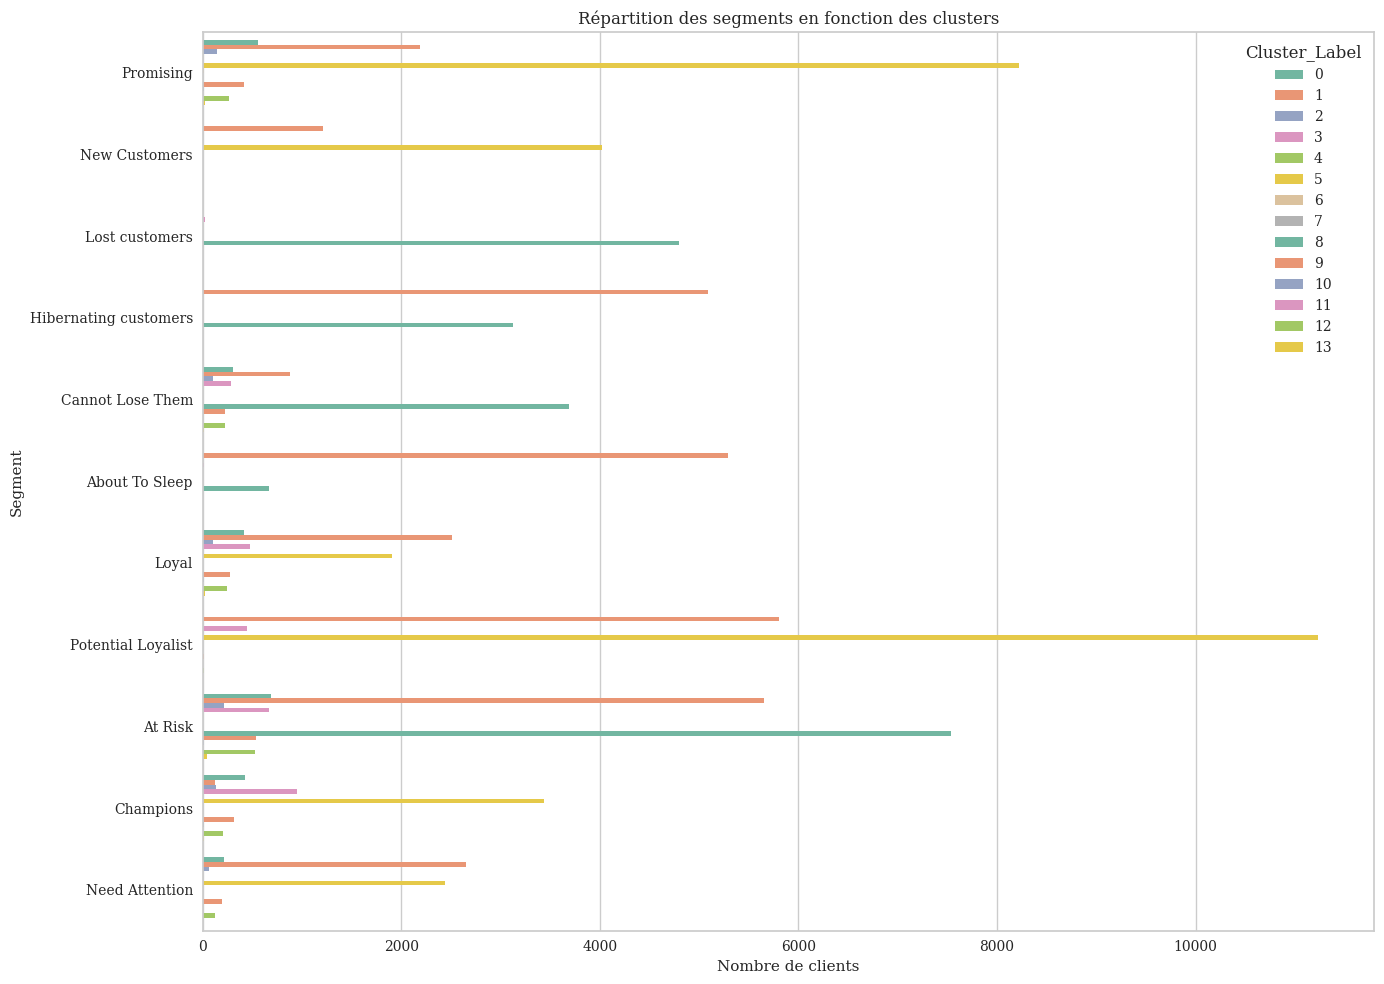

In [16]:
# Augmenter la taille de la figure pour un affichage horizontal
plt.figure(figsize=(14, 10))
sns.countplot(data=df_with_cluster, y='Segment',
              hue='Cluster_Label', palette='Set2',)

plt.title('Répartition des segments en fonction des clusters')
plt.xlabel('Nombre de clients')
plt.ylabel('Segment')

# Ajuster les espacements
plt.tight_layout()

plt.show()